In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [5]:
ts = pd.read_csv('datasets/time_series/renewables_series.csv')
ts['date'] = pd.to_datetime(ts['date'])
ts.set_index('date', inplace=True)
ts.head()

,solar,wind,geothermal,biomass,biogas
date,,,,,
2018-04-12 00:00:00,0.0,4228.0,706.0,242.0,242.0
2018-04-12 00:05:00,0.0,4196.0,716.0,238.0,242.0
2018-04-12 00:10:00,0.0,4214.0,725.0,240.0,241.0
2018-04-12 00:15:00,0.0,4268.0,724.0,241.0,241.0
2018-04-12 00:20:00,0.0,4291.0,724.0,246.0,241.0


In [6]:
ts.shape

(220686, 5)

In [7]:
ts.isnull().sum()

solar         311
wind           24
geothermal    311
biomass        24
biogas         24
dtype: int64

## Calculate mean megawatt demand each hour
- This allows for forecasting data in megawatt hours in future methods

In [8]:
mwh = ts.resample('H').mean()
print(mwh.shape)
mwh.head(3)

(18504, 5)


,solar,wind,geothermal,biomass,biogas
date,,,,,
2018-04-12 00:00:00,0.0,4334.916667,688.250000,243.166667,241.333333
2018-04-12 01:00:00,0.0,4197.000000,654.750000,236.916667,241.083333
2018-04-12 02:00:00,0.0,4250.583333,643.916667,238.333333,242.500000


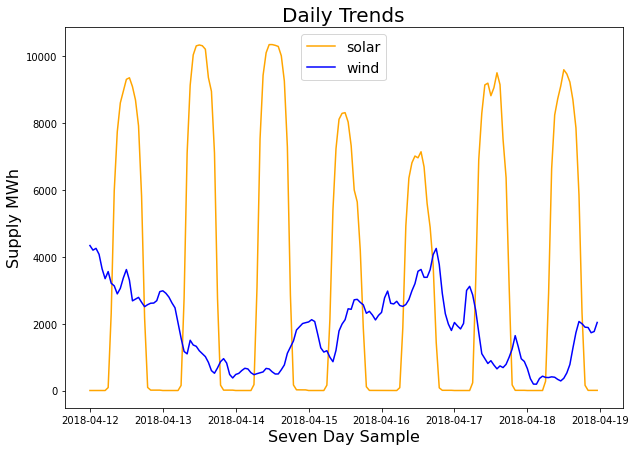

In [22]:
plt.figure(figsize=(10,7))
plt.plot(mwh['solar'][0:24*7],'orange',label='solar')
plt.plot(mwh['wind'][0:24*7],'b-',label='wind')
plt.legend(fontsize=14)
plt.title('Daily Trends',fontsize=20)
plt.xlabel('Seven Day Sample',fontsize=16)
plt.ylabel('Supply MWh',fontsize=16);
plt.savefig('./images/renewable_daily.png',dpi=235,bbox_inches='tight');

### Weekly Renewables
- Supply trends by fuel type showing monthly totals in MWh

In [13]:
ds = mwh.resample('7D').mean()
ds.head(3)

,solar,wind,geothermal,biomass,biogas
date,,,,,
2018-04-12,3584.472312,1829.734443,863.838474,239.467713,223.612734
2018-04-19,3940.009064,2152.392091,921.091360,250.547033,233.807991
2018-04-26,3679.982828,3315.297348,920.409091,294.692045,239.192045


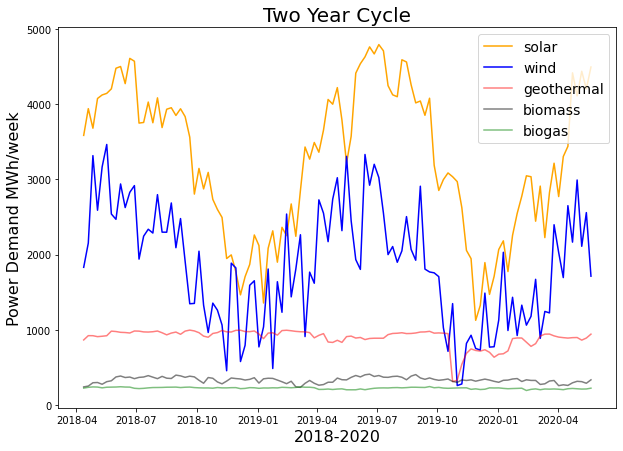

In [17]:
plt.figure(figsize=(10,7))
plt.plot(ds['solar'],'orange',label='solar')
plt.plot(ds['wind'],'b-',label='wind')
plt.plot(ds['geothermal'],'r-',label='geothermal',alpha=0.5)
plt.plot(ds['biomass'],'k-',label='biomass',alpha=0.5)
plt.plot(ds['biogas'],'g-',label='biogas',alpha=0.5)
plt.title('Two Year Cycle',fontsize=20)
plt.legend(fontsize=14)
plt.xlabel('2018-2020',fontsize=16)
plt.ylabel('Power Demand MWh/week',fontsize=16);
#plt.savefig('./images/renewable_seasonal.png',dpi=235,bbox_inches='tight');

### Monthly Renewables

In [89]:
ms = mwh.resample('M').sum()
ms.head()

,solar,wind,geothermal,biomass,biogas
date,,,,,
2018-04-30,1.557772e+06,9.051285e+05,365237.530303,102546.590909,94059.681818
2018-05-31,3.032636e+06,2.219255e+06,694131.606061,225322.000000,174145.068182
2018-06-30,3.226031e+06,1.977369e+06,695515.856061,266780.303030,171650.045455
2018-07-31,2.913979e+06,1.672737e+06,725033.151515,276730.833333,165089.878788
2018-08-31,2.911125e+06,1.890580e+06,713629.318182,268815.590909,173892.893939


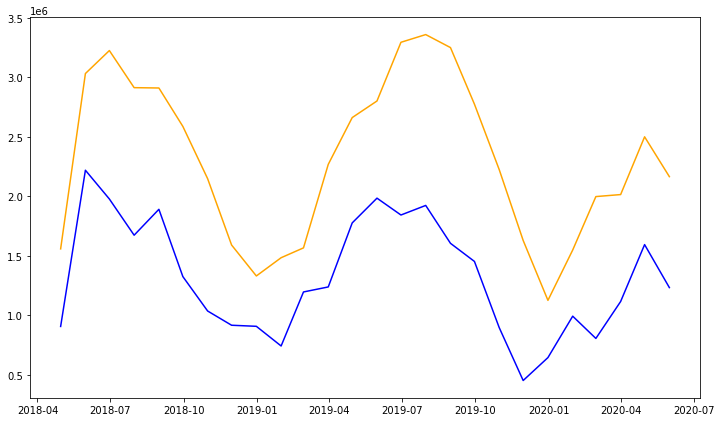

In [90]:
plt.figure(figsize=(12,7))
plt.plot(ms['solar'],'orange')
plt.plot(ms['wind'],'b-')

## Autocorrelation models

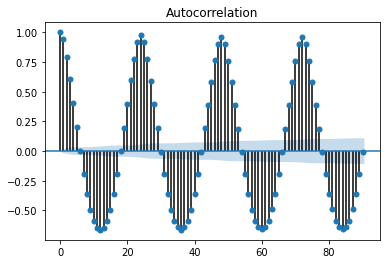

In [98]:
plot_acf(mwh['solar'].fillna(np.mean(mwh['solar'])),lags=90);

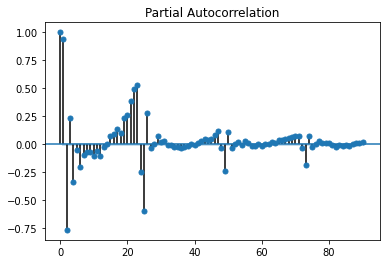

In [97]:
plot_pacf(mwh['solar'].fillna(np.mean(mwh['solar'])),lags=90);

### Two week ahead solar forecast from hourly

RMSE = 632.6985791364715


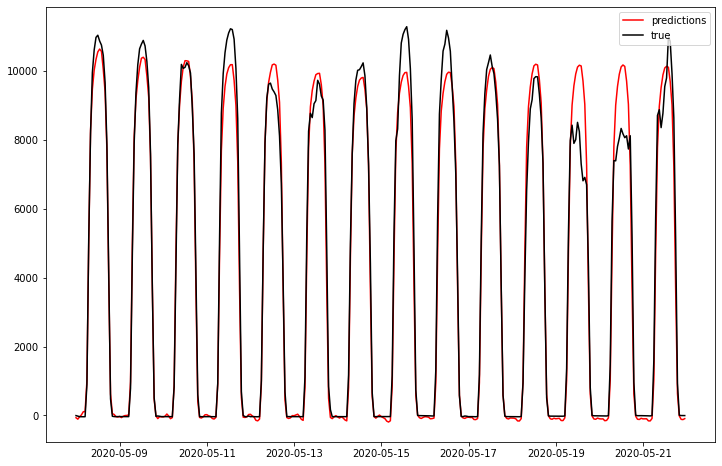

In [103]:
series = mwh['solar'].fillna(np.mean(mwh['solar']))
train,test = series[:24*14*-1], series[24*14*-1:]

model = AutoReg(train,lags=24*13)
model_fit = model.fit()

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

print(f"RMSE = {np.sqrt(mean_squared_error(test, predictions))}")

plt.figure(figsize=(12,8))
plt.plot(predictions,'r',label='predictions')
plt.plot(test,'k',label='true')
plt.legend();

### Day ahead wind forecast from hourly

RMSE = 726.4509112059761


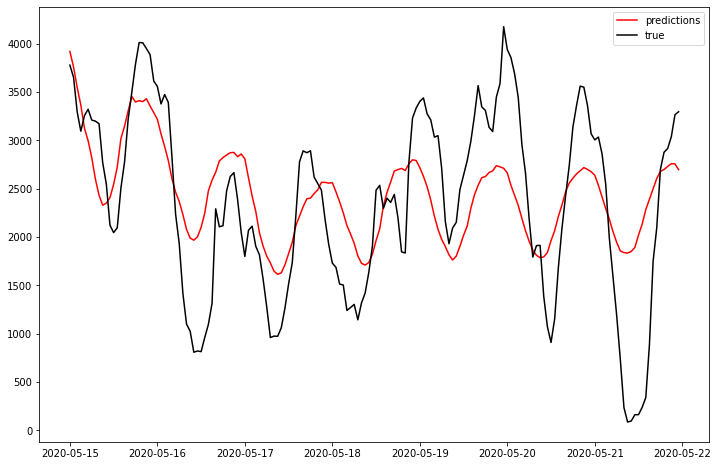

In [106]:
series = mwh['wind'].fillna(np.mean(mwh['wind']))
train,test = series[:24*7*-1], series[24*7*-1:]

model = AutoReg(train,lags=24*13)
model_fit = model.fit()

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

print(f"RMSE = {np.sqrt(mean_squared_error(test, predictions))}")

plt.figure(figsize=(12,8))
plt.plot(predictions,'r',label='predictions')
plt.plot(test,'k',label='true')
plt.legend();

## VAR model
- day of year, hour of day